In [1]:
from typing import SupportsFloat, Sequence, Tuple, Any
import collections
import copy

In [2]:
from rlplg import envplay
from rlplg.learning.tabular import policies

In [3]:
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import wrappers as gym_wrappers
from gymnasium.core import ObsType, ActType

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt

## Utils

In [5]:
def collect_stats(env, total_episodes: int = 2000):
    policy = policies.PyRandomPolicy(num_actions=env.action_space.n)
    # collect data
    idx = 1
    end_game = []
    rewards = set()
    while True:
        traj = tuple(envplay.generate_episodes(env, policy=policy, num_episodes=1))
        for step, traj_step in enumerate(traj):
            rewards.add(traj_step.reward)
            pass
        end_game.append(step + 1)
        if idx % 500 == 0:
            print(f"Iteration {idx}")
        if idx > total_episodes:
            break
        idx += 1
    return sorted(collections.Counter(end_game).items()), sorted(rewards)

In [6]:
class ShiftReward(gym.RewardWrapper):
    def __init__(self, env: gym.Env[ObsType, ActType], delta: float):
        """Constructor for the Reward wrapper."""
        super().__init__(env)
        self.delta = delta
        self.reward_range = (env.reward_range[0] + delta, env.reward_range[1] + delta)

        # Update transition data, if existing
        if hasattr(self.env, "P"):
            transitions = getattr(self.env, "P")
            new_transitions = {}
            for state, action_transitions in transitions.items():
                new_transitions[state] = {}
                for action, transitions in action_transitions.items():
                    new_transitions[state][action] = []
                    for prob, next_state, reward, done in transitions:
                        new_transitions[state][action].append(
                            (prob, next_state, reward + self.delta, done)
                        )
            setattr(self.env, "P", new_transitions)
    
    def reward(self, reward: SupportsFloat) -> SupportsFloat:
        return reward + self.delta

In [7]:
def plot(xs: Sequence[Tuple[Any, int]], xlabel: str):
    values, weights = zip(*xs)
    _, ax = plt.subplots()
    df = pd.DataFrame({"values": values, "weights": weights})
    sns.ecdfplot(df, x="values", weights="weights", ax=ax)
    ax.set_xlabel(xlabel)

In [8]:
def run_env(env, total_episodes: int = 2500):
    print(env)
    print(vars(env))
    egs, rs = collect_stats(env, total_episodes=total_episodes)
    print("End game", egs)
    print("Rewards", rs)
    plot(egs, xlabel="Episode ending step")

## FrozenLake

<TimeLimit<OrderEnforcing<PassiveEnvChecker<FrozenLakeEnv<FrozenLake-v1>>>>>
{'_saved_kwargs': {'max_episode_steps': 100}, 'env': <OrderEnforcing<PassiveEnvChecker<FrozenLakeEnv<FrozenLake-v1>>>>, '_action_space': None, '_observation_space': None, '_reward_range': None, '_metadata': None, '_cached_spec': None, '_max_episode_steps': 100, '_elapsed_steps': None}
Iteration 500
Iteration 1000
Iteration 1500
Iteration 2000
Iteration 2500
End game [(3, 310), (4, 284), (5, 287), (6, 236), (7, 223), (8, 201), (9, 153), (10, 130), (11, 96), (12, 93), (13, 80), (14, 74), (15, 53), (16, 45), (17, 44), (18, 41), (19, 26), (20, 22), (21, 20), (22, 8), (23, 12), (24, 10), (25, 10), (26, 8), (27, 5), (28, 3), (29, 7), (30, 3), (31, 5), (32, 4), (33, 1), (34, 2), (35, 1), (36, 1), (39, 1), (40, 1), (47, 1)]
Rewards [0.0, 1.0]


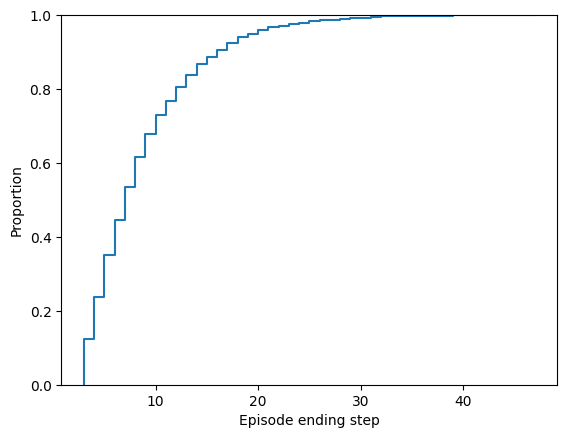

In [9]:
run_env(gym.make("FrozenLake-v1", is_slippery=False))

<ShiftReward<TimeLimit<OrderEnforcing<PassiveEnvChecker<FrozenLakeEnv<FrozenLake-v1>>>>>>
{'env': <TimeLimit<OrderEnforcing<PassiveEnvChecker<FrozenLakeEnv<FrozenLake-v1>>>>>, '_action_space': None, '_observation_space': None, '_reward_range': (-1.0, 0.0), '_metadata': None, '_cached_spec': None, 'delta': -1.0}
Iteration 500
Iteration 1000
Iteration 1500
Iteration 2000
Iteration 2500
End game [(3, 314), (4, 260), (5, 296), (6, 250), (7, 208), (8, 168), (9, 140), (10, 118), (11, 105), (12, 124), (13, 79), (14, 78), (15, 46), (16, 57), (17, 50), (18, 29), (19, 30), (20, 29), (21, 22), (22, 15), (23, 11), (24, 11), (25, 17), (26, 10), (27, 4), (28, 4), (29, 4), (30, 5), (31, 3), (32, 4), (33, 2), (34, 2), (35, 1), (37, 1), (39, 1), (40, 1), (41, 1), (42, 1)]
Rewards [-1.0, 0.0]


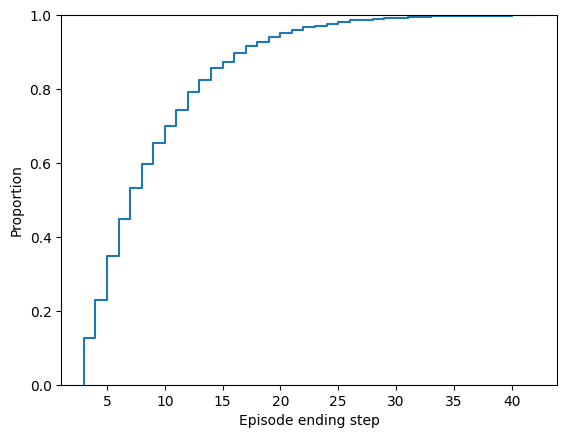

In [10]:
run_env(ShiftReward(gym.make("FrozenLake-v1", is_slippery=False), delta=-1.0))

In [11]:
env = ShiftReward(gym.make("FrozenLake-v1", is_slippery=False), delta=-1.0)
getattr(env, "P")

{0: {0: [(1.0, 0, -1.0, False)],
  1: [(1.0, 4, -1.0, False)],
  2: [(1.0, 1, -1.0, False)],
  3: [(1.0, 0, -1.0, False)]},
 1: {0: [(1.0, 0, -1.0, False)],
  1: [(1.0, 5, -1.0, True)],
  2: [(1.0, 2, -1.0, False)],
  3: [(1.0, 1, -1.0, False)]},
 2: {0: [(1.0, 1, -1.0, False)],
  1: [(1.0, 6, -1.0, False)],
  2: [(1.0, 3, -1.0, False)],
  3: [(1.0, 2, -1.0, False)]},
 3: {0: [(1.0, 2, -1.0, False)],
  1: [(1.0, 7, -1.0, True)],
  2: [(1.0, 3, -1.0, False)],
  3: [(1.0, 3, -1.0, False)]},
 4: {0: [(1.0, 4, -1.0, False)],
  1: [(1.0, 8, -1.0, False)],
  2: [(1.0, 5, -1.0, True)],
  3: [(1.0, 0, -1.0, False)]},
 5: {0: [(1.0, 5, -1.0, True)],
  1: [(1.0, 5, -1.0, True)],
  2: [(1.0, 5, -1.0, True)],
  3: [(1.0, 5, -1.0, True)]},
 6: {0: [(1.0, 5, -1.0, True)],
  1: [(1.0, 10, -1.0, False)],
  2: [(1.0, 7, -1.0, True)],
  3: [(1.0, 2, -1.0, False)]},
 7: {0: [(1.0, 7, -1.0, True)],
  1: [(1.0, 7, -1.0, True)],
  2: [(1.0, 7, -1.0, True)],
  3: [(1.0, 7, -1.0, True)]},
 8: {0: [(1.0, 8, -1

## CliffWalking

<OrderEnforcing<PassiveEnvChecker<CliffWalkingEnv<CliffWalking-v0>>>>
{'_saved_kwargs': {'disable_render_order_enforcing': False}, 'env': <PassiveEnvChecker<CliffWalkingEnv<CliffWalking-v0>>>, '_action_space': None, '_observation_space': None, '_reward_range': None, '_metadata': None, '_cached_spec': None, '_has_reset': False, '_disable_render_order_enforcing': False}
End game [(41, 1), (166, 1), (551, 1), (552, 1), (572, 1), (606, 1), (615, 1), (803, 1), (934, 1), (971, 1), (1034, 1), (1141, 1), (1245, 1), (1568, 1), (1608, 1), (1684, 1), (1860, 1), (1928, 1), (1990, 1), (2057, 1), (2097, 1), (2100, 1), (2119, 1), (2356, 1), (2363, 1), (2529, 1), (2530, 1), (2700, 1), (2717, 1), (2860, 1), (3029, 1), (3103, 1), (3149, 1), (3177, 1), (3229, 1), (3361, 1), (3390, 1), (3498, 1), (3594, 1), (3642, 1), (3669, 1), (3715, 1), (3946, 1), (3952, 1), (4034, 1), (4084, 1), (4398, 1), (4498, 1), (4622, 1), (4834, 1), (4853, 1), (4859, 1), (4976, 1), (5008, 1), (5076, 1), (5443, 1), (5537, 1), (56

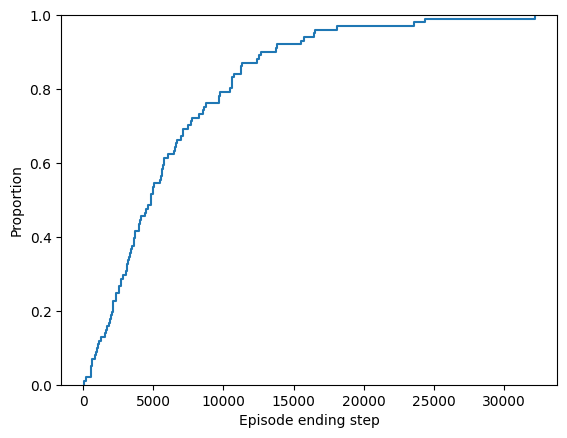

In [12]:
run_env(gym.make("CliffWalking-v0"), total_episodes=100)

<TimeLimit<OrderEnforcing<PassiveEnvChecker<CliffWalkingEnv<CliffWalking-v0>>>>>
{'_saved_kwargs': {'max_episode_steps': 2500}, 'env': <OrderEnforcing<PassiveEnvChecker<CliffWalkingEnv<CliffWalking-v0>>>>, '_action_space': None, '_observation_space': None, '_reward_range': None, '_metadata': None, '_cached_spec': None, '_max_episode_steps': 2500, '_elapsed_steps': None}
Iteration 500
Iteration 1000
Iteration 1500
Iteration 2000
Iteration 2500
End game [(14, 1), (35, 1), (49, 1), (50, 1), (53, 1), (54, 2), (58, 1), (63, 2), (66, 1), (68, 1), (78, 1), (80, 1), (84, 1), (86, 1), (88, 1), (89, 2), (91, 1), (101, 1), (106, 1), (110, 1), (113, 1), (114, 1), (121, 1), (123, 1), (127, 1), (128, 2), (129, 1), (131, 1), (140, 1), (143, 1), (145, 1), (146, 1), (147, 1), (150, 1), (157, 1), (159, 2), (161, 1), (162, 1), (167, 1), (170, 1), (172, 1), (174, 2), (178, 2), (180, 1), (183, 1), (185, 1), (190, 1), (191, 1), (193, 2), (194, 1), (201, 1), (202, 1), (205, 1), (207, 1), (208, 1), (210, 1), 

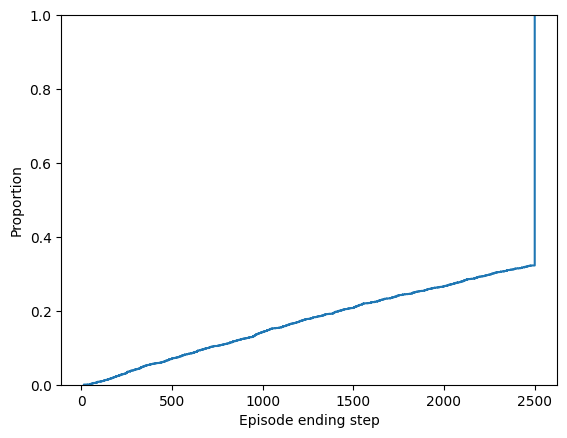

In [13]:
run_env(gym.make("CliffWalking-v0", max_episode_steps=2500))

Between [20-35%) of episodes would end before 2500 steps.

## Taxi-v3

We override the default limit of 200 steps, since it creates a scarcity of observations of the final state.

<TimeLimit<OrderEnforcing<PassiveEnvChecker<TaxiEnv<Taxi-v3>>>>>
{'_saved_kwargs': {'max_episode_steps': inf}, 'env': <OrderEnforcing<PassiveEnvChecker<TaxiEnv<Taxi-v3>>>>, '_action_space': None, '_observation_space': None, '_reward_range': None, '_metadata': None, '_cached_spec': None, '_max_episode_steps': inf, '_elapsed_steps': None}
Iteration 500
Iteration 1000
Iteration 1500
Iteration 2000
Iteration 2500
End game [(28, 1), (32, 1), (42, 2), (46, 1), (53, 1), (56, 1), (57, 1), (63, 1), (76, 3), (79, 1), (80, 1), (86, 1), (87, 1), (90, 1), (92, 1), (93, 1), (94, 1), (96, 2), (99, 1), (102, 3), (105, 1), (106, 1), (108, 1), (111, 1), (115, 1), (117, 3), (119, 2), (121, 1), (123, 1), (127, 2), (129, 1), (131, 1), (132, 1), (134, 2), (137, 1), (138, 1), (139, 1), (140, 1), (143, 1), (145, 2), (147, 1), (148, 1), (149, 1), (152, 1), (154, 2), (155, 3), (157, 2), (160, 4), (163, 2), (165, 1), (167, 2), (168, 2), (169, 1), (170, 1), (172, 2), (174, 2), (175, 1), (178, 1), (179, 1), (180, 

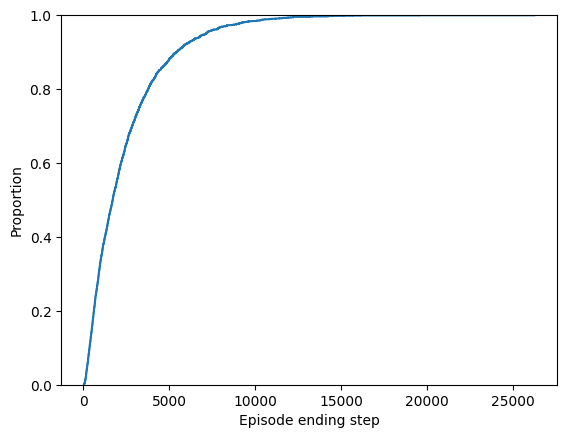

In [14]:
run_env(gym.make("Taxi-v3", max_episode_steps=np.inf))

<TimeLimit<OrderEnforcing<PassiveEnvChecker<TaxiEnv<Taxi-v3>>>>>
{'_saved_kwargs': {'max_episode_steps': 2500}, 'env': <OrderEnforcing<PassiveEnvChecker<TaxiEnv<Taxi-v3>>>>, '_action_space': None, '_observation_space': None, '_reward_range': None, '_metadata': None, '_cached_spec': None, '_max_episode_steps': 2500, '_elapsed_steps': None}
Iteration 500
Iteration 1000
Iteration 1500
Iteration 2000
Iteration 2500
End game [(24, 1), (39, 1), (45, 1), (50, 1), (59, 1), (61, 1), (68, 1), (70, 1), (71, 1), (74, 1), (78, 1), (80, 1), (82, 1), (84, 1), (86, 3), (87, 1), (95, 1), (98, 1), (99, 1), (103, 1), (105, 2), (109, 2), (112, 1), (114, 2), (115, 1), (117, 1), (122, 1), (123, 2), (126, 1), (127, 2), (130, 1), (131, 1), (132, 1), (133, 2), (134, 1), (136, 1), (137, 2), (139, 1), (140, 1), (142, 1), (143, 2), (145, 3), (146, 2), (148, 1), (149, 1), (150, 2), (152, 1), (155, 1), (156, 1), (159, 4), (160, 1), (161, 2), (164, 2), (165, 1), (166, 1), (168, 1), (170, 1), (171, 2), (172, 2), (173

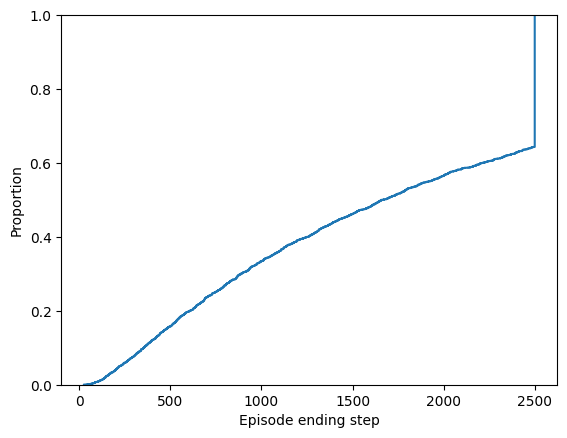

In [15]:
run_env(gym.make("Taxi-v3", max_episode_steps=2500))

About ~60% of episodes end before step 2500. We also observe the reward for successful outcomes, so the terminal states should be present in the data buffer.

## Blackjack

Blackjack is already a discrete state problem. We need only convert its 3-tuple state into a single `int` value.
Though the environment is unsuitable for DAAF, since it's a sparse reward problem - with rewards given only at the end.

<OrderEnforcing<PassiveEnvChecker<BlackjackEnv<Blackjack-v1>>>>
{'_saved_kwargs': {'disable_render_order_enforcing': False}, 'env': <PassiveEnvChecker<BlackjackEnv<Blackjack-v1>>>, '_action_space': None, '_observation_space': None, '_reward_range': None, '_metadata': None, '_cached_spec': None, '_has_reset': False, '_disable_render_order_enforcing': False}
Iteration 500
Iteration 1000
Iteration 1500
Iteration 2000
Iteration 2500
End game [(2, 1755), (3, 624), (4, 107), (5, 15)]
Rewards [-1.0, 0.0, 1.0]


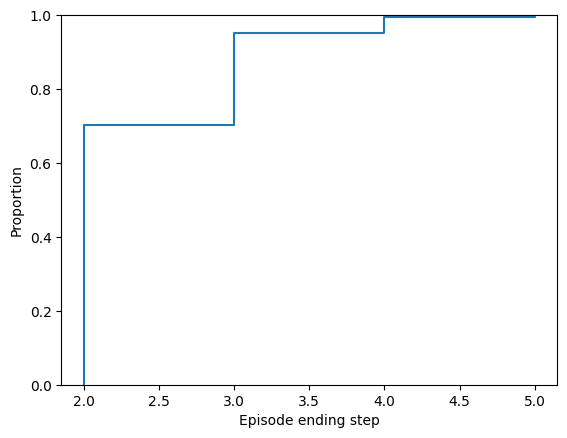

In [16]:
run_env(gym.make("Blackjack-v1"))

In [17]:
env = gym_wrappers.FlattenObservation(gym.make("Blackjack-v1"))
print(env.observation_space)
print(env.reset())

Box(0, 1, (45,), int64)
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0]), {})


`FlattenObservation` generates OHE arrays instead of integers for states.
Will need a custom process to discretize blackjack.

In [18]:
env = gym.make("Blackjack-v1")
dims = [space.n for space in env.observation_space]
print(dims)
current_sum, dealer_hand, has_ace = dims
size = np.product(dims)
pos_hist = {}
idx = 0
for csum in range(current_sum):
    for hand in range(dealer_hand):
        for ace in range(has_ace):
            pos_hist[(csum, hand, ace)] = idx
            idx += 1

assert size == len(pos_hist), f"{size} != {len(pos_hist)}"

[32, 11, 2]


## Mountain Car

In [19]:
# https://gymnasium.farama.org/environments/classic_control/mountain_car/
# speed and velocity changes
# velocityt+1 = velocityt + (action - 1) * force - cos(3 * positiont) * gravity
# positiont+1 = positiont + velocityt+1
# velocity delta
force = 0.001
gravity = 0.0025
positions = []
speeds = []
deltas = []
for positiont in np.arange(-1.2, 0.6, 0.1):
    for velocity in np.arange(-0.7, 0.7, 0.1):
        for action in range(3):
            delta = (action - 1) * force - np.cos(3 * positiont) * gravity
            v_ = velocity + delta
            deltas.append(delta)
            speeds.append(v_)
            positions.append(positiont + v_)

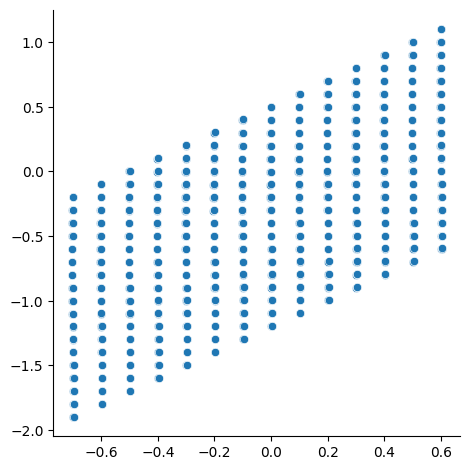

In [20]:
sns.relplot(x=speeds, y=positions)

<Axes: ylabel='Count'>

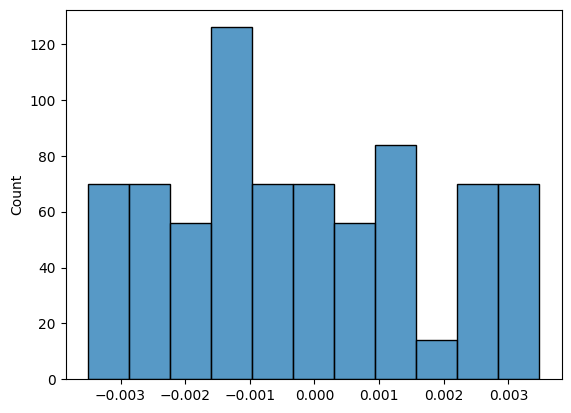

In [21]:
sns.histplot(deltas)

Differences are very minute. Discretization would lead to very large state spaces

In [22]:
# state space after discretization
len(np.arange(-1.2, 0.6, 0.001)) * len(np.arange(-0.7, 0.7, 0.001))

2520000